# In this work we will see how SALib can be applied to analyze the weight of different factors in model.py

# Import basic components from IPython library

In [2]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

# The model used for this seminar is contained in the file model.py
from model import (cost_of_vehicle_to_grid, compute_profit,
                   annualized_capital_cost, battery_lifetime,
                   max_vehicle_power)
import pandas as pd
file_path = 'car_information.csv'
df = pd.read_csv(file_path)

# Import morris from SALib

SALib is a **free** **open-source** **Python** library

If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))


In [3]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [4]:
def monte_carlo_large(data):
    dispatch_time = 4
    y = max_vehicle_power(data[0], data[1], data[2], data[3], data[6], data[4], data[5])
    return y

### Using morris in SALib to analyze the models

In [5]:
morris_problem = {
    # There are six variables
    'num_vars': 7,
    # These are their names
    'names': ['conn', 'batt', 'dist', 'range',
              'dri_eff', 'inv_eff', 'dispatch_time'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[2.3, 22], # connection_power (kW)
               [50, 100], # battery size (kWh)
               [0, 80], # distance driven (km)
               [0, 80], # range buffer (km)
               [4,5.5], # driving efficiency (kWh/km)
               [0.87,0.97], # inverter efficienct (%)
               [0.5, 24] # dispatch time - hours of the day in which
                         # the energy is dispatched
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [6]:
number_of_trajectories = 1000
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)

### Factor Prioritisation

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [7]:
# Run the sample through the monte carlo procedure of the power model
output = monte_carlo_large(sample.T)
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'],
                              Si['mu'],
                              Si['mu_star'],
                              Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
conn                    5.52    5.52    7.95
batt                    2.00    2.00    2.01
dist                 -  0.69    0.69    0.66
range                -  0.67    0.67    0.69
dri_eff                 0.23    0.23    0.28
inv_eff                 0.25    0.25    0.28
dispatch_time        -  9.30    9.30    8.85


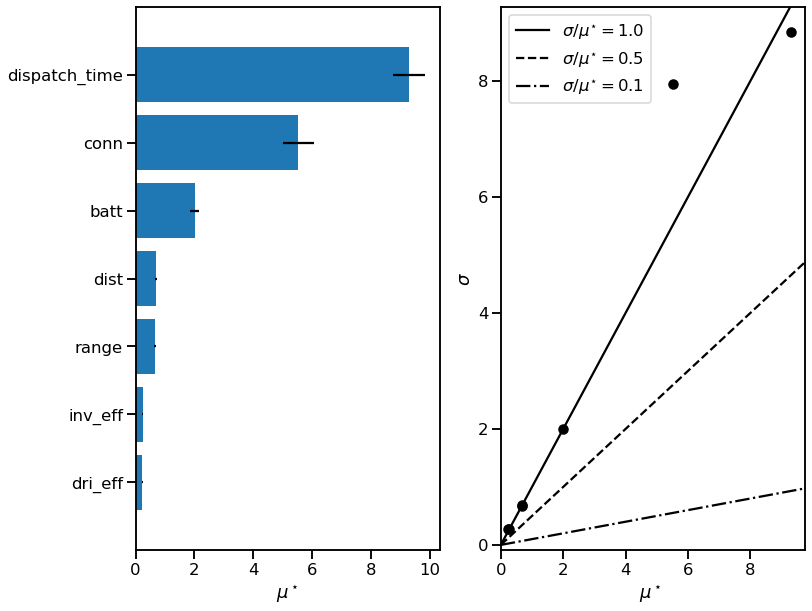

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})

In [9]:
number_sims = 1000

# Make some random data in the correct ranges
mc_connector = np.random.uniform(2.3, 22, number_sims)
mc_battery_size = np.random.uniform(50, 100, number_sims)
mc_distance_driven = np.random.uniform(0, 80, number_sims)
mc_range_buffer = np.random.uniform(0, 80, number_sims)
mc_driving_eff = np.random.uniform(2, 6, number_sims)
mc_inv_eff = np.random.uniform(0.87, 0.97, number_sims)
mc_dispatch_time = np.random.uniform(0.5, 24, number_sims)

data = np.array((mc_connector,
                 mc_battery_size,
                 mc_distance_driven,
                 mc_range_buffer,
                 mc_driving_eff,
                 mc_inv_eff,
                 mc_dispatch_time))

# Run the code
y = monte_carlo_large(data)

# The datas will be organized in a manner in which the more related factor will be ranked higher.
We can see connector size is the factor the most related.

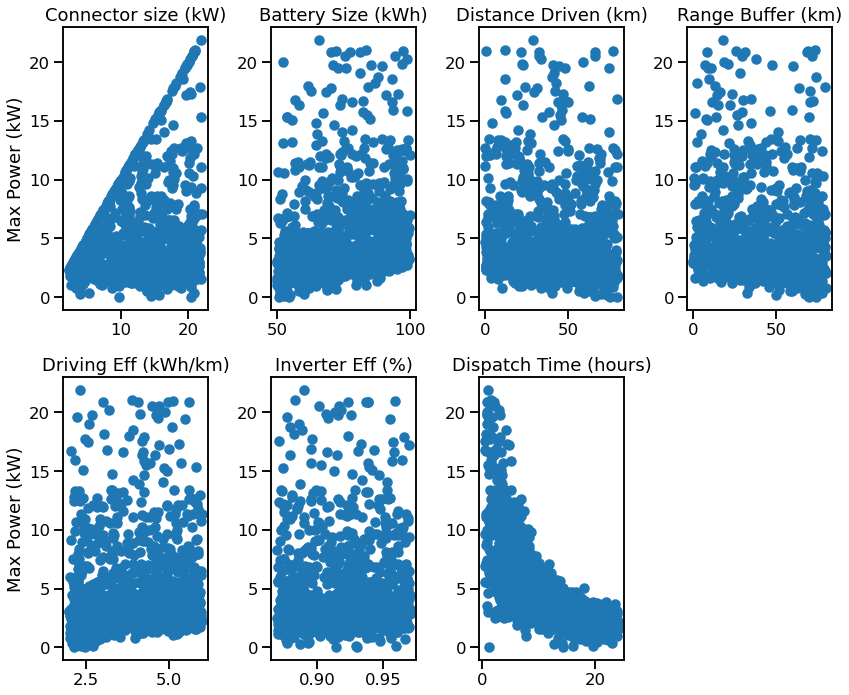

In [10]:
# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(242)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
# plt.ylabel("Max Power (kW)")
plt.subplot(243)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(244)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(245)
plt.scatter(mc_driving_eff, y)
plt.title("Driving Eff (kWh/km)")
plt.ylabel("Max Power (kW)")
plt.subplot(246)
plt.scatter(mc_inv_eff, y)
plt.title("Inverter Eff (%)")
# plt.ylabel("Max Power (kW)")
plt.subplot(247)
plt.scatter(mc_dispatch_time, y)
plt.title("Dispatch Time (hours)")
# plt.ylabel("Max Power (kW)")
plt.tight_layout()
# plt.savefig('scatter.png')

# This is the easy analyzing process. Then we will consider a more complex situation, in which we consider more factors.

In [26]:
def plot_profit(battery_size,
                battery_unit_cost,
                connector_power,
                lifetime_cycles,
                depth_of_discharge,
                electricity_price,
                purchased_energy_cost,
                capacity_price,
                round_trip_efficiency,
                cost_of_v2g_equip,
                discount_rate,
                economic_lifetime,
                distance_driven,
                range_buffer,
                ratio_dispatch_to_contract,
                hours_connected_per_day):
    profit, revenue, cost = compute_profit(battery_size,
                                           battery_unit_cost,
                                           connector_power,
                                           lifetime_cycles,
                                           depth_of_discharge,
                                           electricity_price,
                                           purchased_energy_cost,
                                           capacity_price,
                                           round_trip_efficiency,
                                           cost_of_v2g_equip,
                                           discount_rate,
                                           economic_lifetime,
                                           distance_driven,
                                           range_buffer,
                                           ratio_dispatch_to_contract,
                                           hours_connected_per_day
                                           )

In [27]:
from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa

problem = {
    'num_vars': 16,
    'names': ['battery_size',
              'battery_unit_cost',
              'connector_power',
              'lifetime_cycles',
              'depth_of_discharge',
              'electricity_price',
              'purchased_energy_cost',
              'capacity_price',
              'round_trip_efficiency',
              'cost_of_v2g_equip',
              'discount_rate',
              'economic_lifetime',
              'distance_driven',
              'range_buffer',
              'ratio_dispatch_to_contract',
              'hours_connected_per_day'],
    'bounds': [       
                [10, 100],
                [100, 400],
                [2.3, 22],
                [1000, 10000],
                [0.5, 1.0],
                [0.01, 0.2], 
                [0.01, 0.2],
                [0.001, 0.01], 
                [0.65, 1.0],
                [100, 5000],
                [0.0, 0.2], 
                [3, 25],
                [0, 100], 
                [0, 100], 
                [0.01, 0.50],
                [0.5, 24],
              ],
    'groups': None
    }

In [29]:

def plot_profit(battery_size,
                purchased_energy_cost,
                cost_of_v2g_equip,
                economic_lifetime,
                ratio_dispatch_to_contract,
                lifetime_cycles):
    profit, revenue, cost = compute_profit(lifetime_cycles=lifetime_cycles,
                                           battery_size=battery_size,
                                           purchased_energy_cost=purchased_energy_cost,
                                           cost_of_v2g_equip=cost_of_v2g_equip,
                                           economic_lifetime=economic_lifetime,
                                           ratio_dispatch_to_contract=ratio_dispatch_to_contract
                                           )

In [30]:
sample = ss(problem, 1000, calc_second_order=False)
profit, revenue, cost = compute_profit(sample[:, 0], sample[:, 1], sample[:, 2], 
                                       sample[:, 3], sample[:, 4], sample[:, 5], 
                                       sample[:, 6], sample[:, 7], sample[:, 8], 
                                       sample[:, 9], sample[:, 10], sample[:, 11], 
                                       sample[:, 12], sample[:, 13], sample[:, 14], 
                                       sample[:, 15])
SI = sa(problem, profit, calc_second_order=False, print_to_console=False)
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(problem['names'], SI['S1'], SI['ST'], sample.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

Name                           1st Total Mean of Input
battery_size                 -0.01  0.26 (       55.02)
battery_unit_cost             0.01  0.03 (      250.07)
connector_power               0.01  0.04 (       12.14)
lifetime_cycles               0.04  0.10 (     5498.96)
depth_of_discharge            0.01  0.03 (        0.75)
electricity_price             0.01  0.06 (        0.10)
purchased_energy_cost         0.03  0.12 (        0.10)
capacity_price                0.01  0.04 (        0.01)
round_trip_efficiency         0.00  0.01 (        0.82)
cost_of_v2g_equip             0.26  0.33 (     2550.26)
discount_rate                 0.05  0.08 (        0.10)
economic_lifetime             0.13  0.16 (       14.01)
distance_driven              -0.01  0.03 (       49.97)
range_buffer                 -0.01  0.03 (       49.96)
ratio_dispatch_to_contract    0.07  0.27 (        0.26)
hours_connected_per_day      -0.01  0.05 (       12.25)


The results show that the most important parameters are:
* Capital cost of the V2G equipment
* Ratio of dispatch to contract
* Battery size
* Economic lifetime
* Purchased energy cost

Other comments:
* __Lifetime cycles__ has a reasonably important first order effect so we can include that too.
* __Battery size__ has much more important interaction effects than first-order effects
* Same for __Purchased_energy_cost__

This is just another case study. Any model can be performed in this way and use Morris to do some analysis.
In this way, we will be able to know the factor weight within a model and understand how the model decide which is the most important factor when it is going to make a decision.